In [ ]:
import numpy 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math

import Vae_ResidualBlock

from torch.nn import functional as F
import Vae_AttentionBlock
import SelfAttention
import ClipEmbedding , ClipLayer , Clip

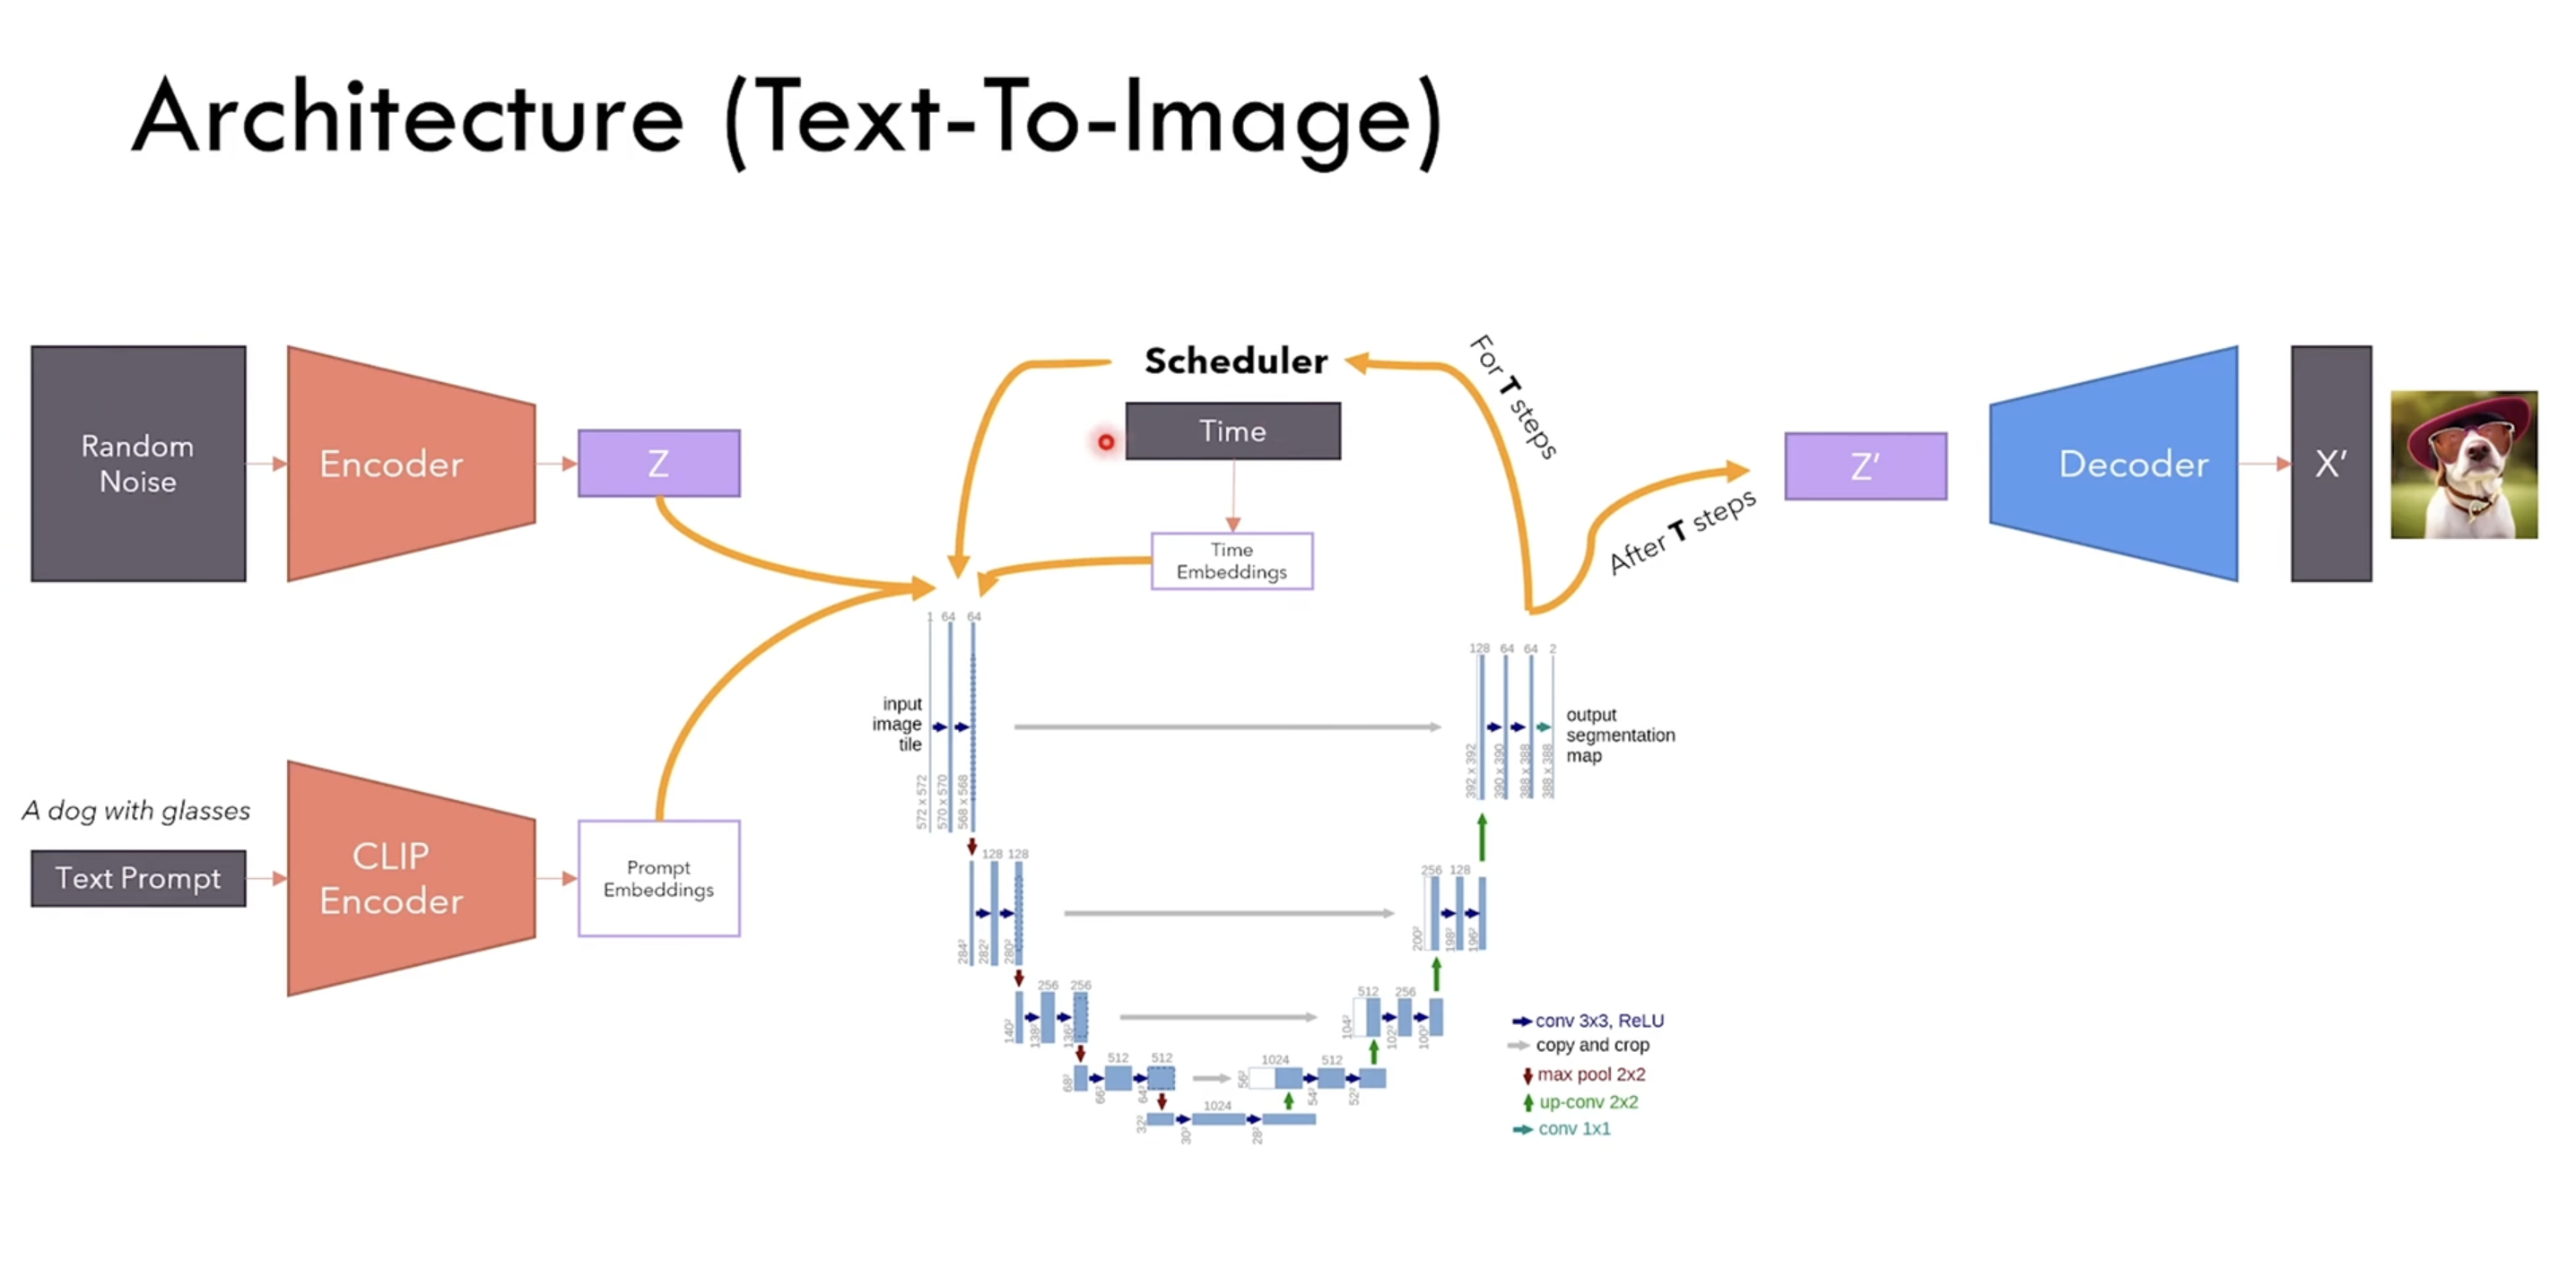
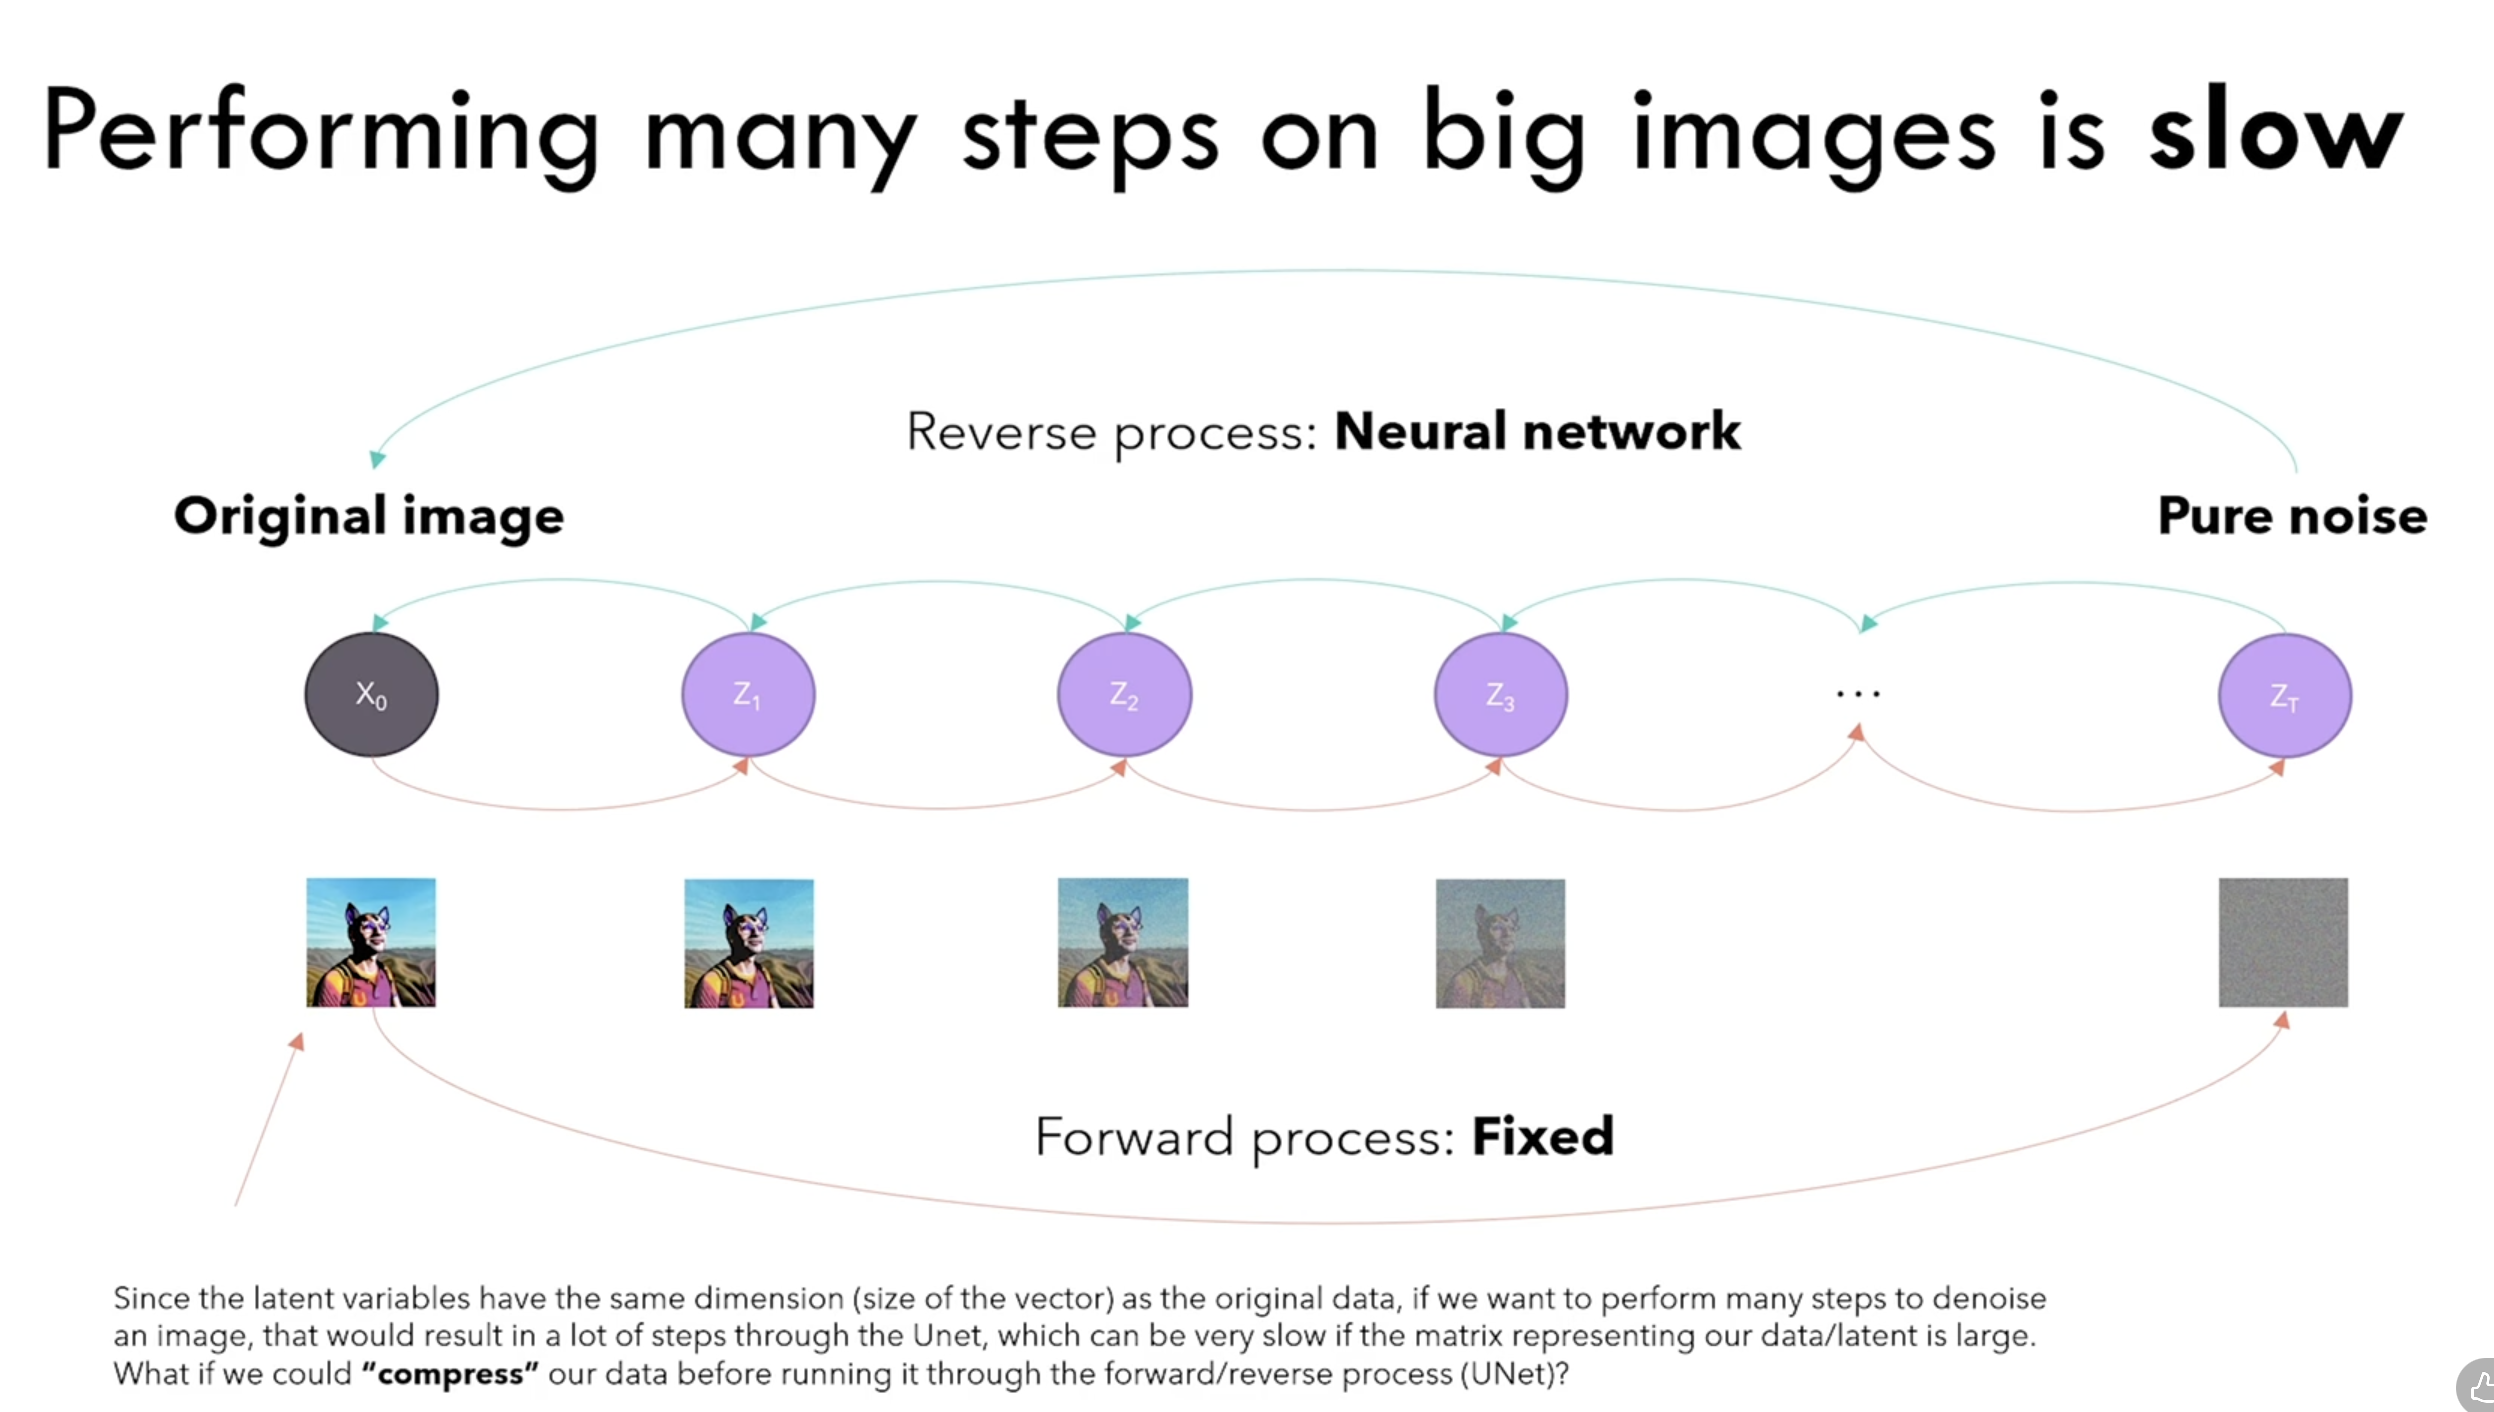

# first we will start with encoder (variational auto encoder)
- why vae --> processing images in u net could be very expensive hence instead of the image itself we use latent represenation of the image


In [ ]:
class VAE_Encoder(nn.Sequential):

    def __init__(self):

        super().__init__(

            nn.Conv2d(3, 128 , kernel_size=3 , padding = 1),               # batch_size , channel , height , width -> (batch_size , 128  , height , width) 
            Vae_ResidualBlock(128, 128 ),   #(batch_size, 128 , height , width) --> (batch_size , 128 , height , width)
            Vae_ResidualBlock(128, 128),    #(batch_size, 128 , height , width) --> (batch_size , 128 , height , width)

            nn.Conv2d(128, 128 , kernel_size=3 , stride = 2, padding = 0),  # (batch_size , 128 , height , width) -> (batch_size , 128 , height/2 , width/2)
            Vae_ResidualBlock(128, 256 ),  # (batch_size , 128 , height/2 , width/2) -> (batch_size , 256 , height/2 , width/2)
            Vae_ResidualBlock(256, 256 ),  # (batch_size , 256 , height/2 , width/2) -> (batch_size , 256 , height/2 , width/2)

            nn.Conv2d(256, 256 , kernel_size=3 , stride = 2, padding = 0),  # (batch_size , 256 , height/2 , width/2) -> (batch_size , 256 , height/4 , width/4)
            Vae_ResidualBlock(256, 512 ),  # (batch_size , 256 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            Vae_ResidualBlock(512, 512 ),  # (batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)

            nn.Conv2d(512, 512, kernel_size=3 , stride = 2, padding = 0),  # (batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/8 , width/8)
            Vae_ResidualBlock(512, 512 ),   #(batch_size , 512 , height/8 , width/8) -> (batch_size , 512 , height/8 , width/8)
            Vae_ResidualBlock(512, 512 ),   #(batch_size , 512 , height/8 , width/8) -> (batch_size , 512 , height/8 , width/8)

            Vae_ResidualBlock(512, 512 ),   #(batch_size , 512 , height/8 , width/8) -> (batch_size , 512 , height/8 , width/8)
            Vae_AttentionBlock(512),        #(batch_size , 512 , height/8 , width/8) -> (batch_size , 512 , height/8 , width/8) 
            Vae_ResidualBlock(512, 512),     #(batch_size , 512 , height/8 , width/8) -> (batch_size , 512 , height/8 , width/8)

            nn.GroupNorm(32, 512),         

            nn.SiLU(), 

            nn.Conv2d(512 , 8 , kernel_size = 3 , padding = 1), #  (batch_size , 512 , height/8 , width/8) -> (batch_size , 8 , height/8 , width/8)

            nn.Conv2d(8 , 8 , kernel_size = 1 , padding = 0),   # (batch_size , 8 , height/8 , width/8) -> (batch_size , 8 , height/8 , width/8)

        )

    def forward(self, x: torch.Tensor , noise: torch.Tensor):   # data(x), noise = (batchsize , channel , height , width)

        for module in self:
            if getattr(module , "stride", None ) == (2,2):
                x = F.pad(x , (0,1,0,1)) 
            x = module(x)

        log_variance = torch.clamp(log_variance , -30 , 20)  #clamping all the values between -30 and 20 for stability(all values less than -30 are set to -30 and all values greater than 20 are set to 20)
        mean , log_variance = torch.chunk(x , 2 , dim=1)    #(batch_size , 8 , height/8 , width/8) --> 2*  (batch_size , 4 , height/8 , width/8)
        variance = log_variance.exp()
        stdev= variance.sqrt()
        
        x = mean + stdev * noise
        x *= 0.8214     #scaling factor for stability(no idea where this number came from)


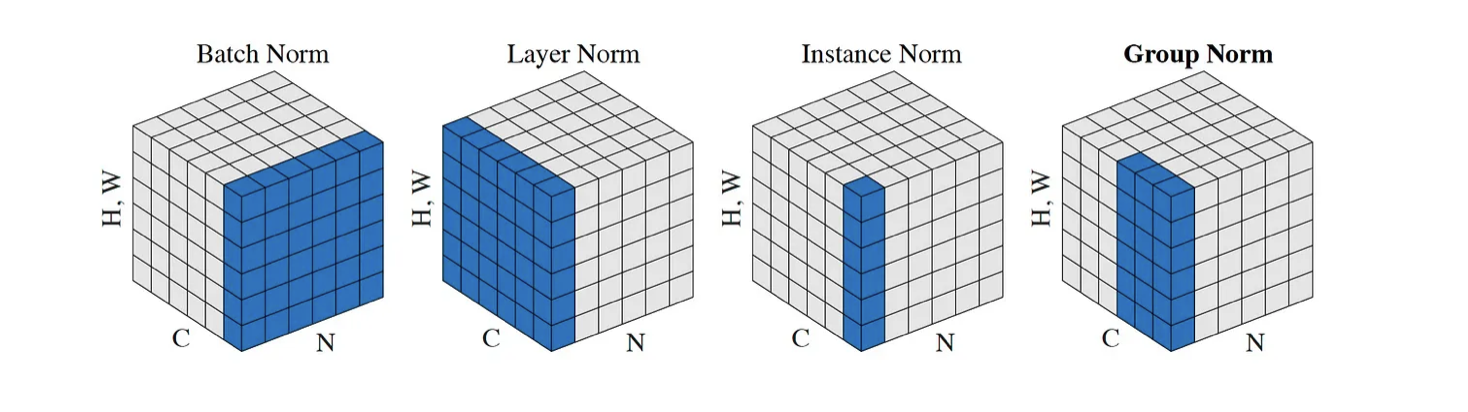
- data(x) = (batchsize , channel , height , width)
- noise = (batchsize , channel , height , width)
- kernel 3 with padding 1 keep shte same resolution
- kernal 1 with padding 0 can be seen as channel mixing information
- torch.chunk --> divides the dimension(dim=1) so that the channel is now divided into two parts 
- why group normalization --> 1. independent of batch size_ since in diffusion modle which are highly memory intensive we can afford to have large 
batch size 2. for smaller batches it outperform es the bn , however for larger batches , bn is better (need to know the technicalitites)
- why do we only use right and bottom padding --> one could use left and top won't make a difference 
- why padding --> for odd number of pixels aplying stride of 2 by 2 either stripes off the last row or column hence we pad the right and bottom with 1 pixel each, while in the case of even padding won't make a differnce becasue the last row or column will be left out
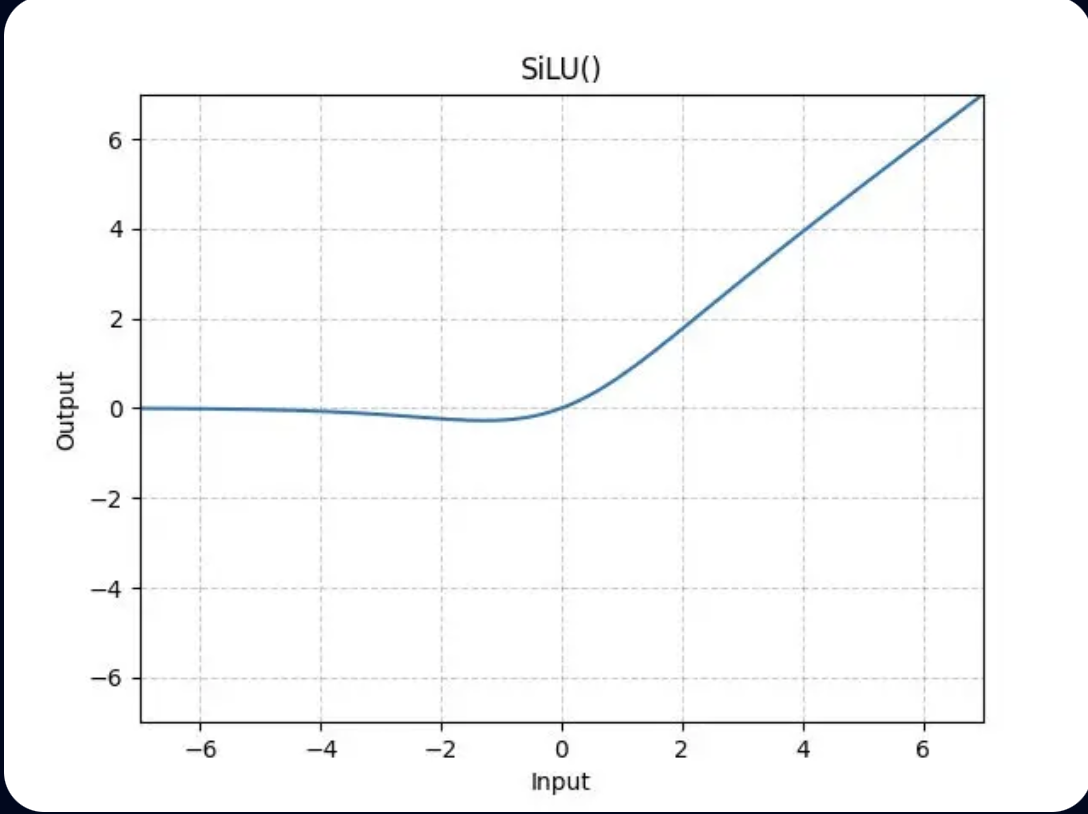
- why silu () --> large diffusion models like smopoth flow of gradient, and unlike relu, it has a small benidning curev at the bottom which facilitieistaes gradient flow, however one could argue why silu(not any other activation(in this large pool of activation), so the choice of the activation  functions are mostly empirical, hecne we can't prove why this particular activation works better than another, but we can argue the from the empirical results that this indeed work better in pratice)
- why clamp when we can normalie 
- vae is not compressed form of image , it is the distribution of the image in the latent space, and now we use that distribution to take sampples and recoinstruct the image
- log_varince --> fo rnumerical stability 
# coding variational autoencoder 
- 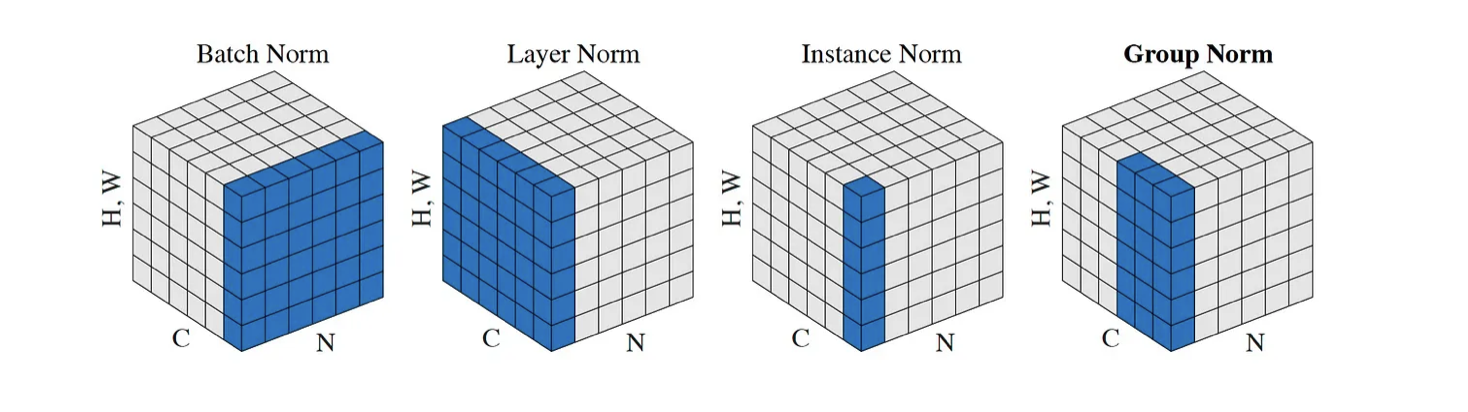


In [ ]:

x = torch.tensor([-100.0, -40.0, 0.0, 10.0, 100.0])
y = torch.clamp(x, min=-30.0, max=20.0)
y


tensor([-30., -30.,   0.,  10.,  20.])

# vae block architecture 

In [4]:
class Vae_ResidualBlock(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()

        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels , out_channels, kernel_size=3 , padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3 , padding=1)

        #skip connection(smooth gradient flow)
        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else :
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self , x: torch.Tensor) -> torch.Tensor:
        
        residue = x             # residue = (batchsize , in_channels , height , width), x = (batchsize , in_channels , height , width)
        x = self.groupnorm_1(x)
        x = F.silu(x)
        x = self.conv_1(x)
        x = self.groupnorm_2(x)
        x = F.silu(x)
        x = self.conv_2(x)

        return x + self.residual_layer(residue)


- the input channel of x is taken before processig layers if the input channel is same as the output channle a(group , conv) after processing then the residual network is identuyt otherwise conv layer

In [ ]:
    
#decoder 

class VAE_Decoder(nn.Sequential):

    def __init__(self):

        super().__init__(
            nn.Conv2d(4, 4 , kernel_size=1 , padding = 0),        #(batch_size, 4 , height/8 , width/8) --> (batch_size , 4 , height/8 , width/8) , padding = 1
            nn.Conv2d(4 , 512 , kernel_size = 3 , padding = 1),     #(batch_size, 4 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8) , padding = 1


            Vae_ResidualBlock(512, 512 ),        #(batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8)
            Vae_AttentionBlock(512),            #(batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8)
            Vae_ResidualBlock(512, 512),        #(batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8)
            Vae_ResidualBlock(512, 512 ),       #(batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8)
            Vae_ResidualBlock(512, 512),       #(batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8)
            Vae_ResidualBlock(512, 512 ),      #(batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8)

            # upsampling by taking the value from the nearest neighbour
            nn.Upsample(scale_factor=2),        # (batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/4 , width/4)

            nn.Conv2d(512, 512 , kernel_size=3 ,padding = 1),   # (batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            nn.Conv2d(512, 512 , kernel_size=3 ,padding = 1),   # (batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            Vae_ResidualBlock(512, 512 ),                   #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            Vae_ResidualBlock(512, 512 ),                   #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            Vae_ResidualBlock(512, 512 ),                   #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)

            nn.Conv2d(512, 512, kernel_size=3 , stride = 2, padding = 0),   #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/2 , width/2)
            Vae_ResidualBlock(512, 512 ),                    #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            Vae_ResidualBlock(512, 512 ),                       #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            Vae_ResidualBlock(512, 512 ),            #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)

            nn.Upsample(scale_factor=2),        #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/2 , width/2)

            nn.Conv2d(512, 512, kernel_size=3 , padding = 1),   #(batch_size , 512 , height/2 , width/2) -> (batch_size , 512 , height/2 , width/2)
            Vae_ResidualBlock(512, 512 ),                    #(batch_size , 512 , height/2 , width/2) -> (batch_size , 512 , height/2 , width/2)
            Vae_ResidualBlock(512, 512 ),                       #(batch_size , 512 , height/2 , width/2) -> (batch_size , 512   , height/2 , width/2)       
            Vae_ResidualBlock(512, 256 ),       #(batch_size , 512 , height/2 , width/2) -> (batch_size , 256 , height/2 , width/2)
            Vae_ResidualBlock(256, 256 ),       #(batch_size , 256 , height/2 , width/2) -> (batch_size , 256 , height/2 , width/2)
            Vae_ResidualBlock(256, 256 ),       #(batch_size , 256 , height/2 , width/2) -> (batch_size , 256 , height/2 , width/2)

            nn.Upsample(scale_factor=2),     #(batch_size , 256 , height/2 , width/2) -> (batch_size , 256 , height , width)

            nn.Conv2d(256, 256, kernel_size=3 , padding = 1),   #(batch_size , 256 , height , width) -> (batch_size , 256 , height , width)
            Vae_ResidualBlock(256 ,128),        #(batch_size , 256 , height , width) -> (batch_size , 128 , height , width)
            Vae_ResidualBlock(128, 128 ),       #(batch_size , 128 , height , width) -> (batch_size , 128 , height , width)
            Vae_ResidualBlock(128, 128 ),       #(batch_size , 128 , height , width) -> (batch_size , 128 , height , width)

            nn.GroupNorm(32, 128),      # divide 128 features in group of 32

            nn.SiLU(),

            nn.Conv2d(128 , 3 , kernel_size=3 , padding=1)    # (batch_size , 128 , height , width) -> (batch_size , 3 , height , width)

        )

    def forward(self , x):
            
            x /= 0.18214    #dividing by the same number which was multiplied in the encoder for stability

            for module in self:
                 x= module(x)

            return x
    

# attention block 

In [ ]:
# attention block 

class Vae_AttentionBlock(nn.Module):
    
    def __init__(self , channels: int):

        super().__init__()

        self.groupnorm = nn.GroupNorm(32 , channels)
        self.attention = SelfAttention(1, channels)

    def forward(self, x: torch.Tensor):

        residue = x     #residue, x = (batchsize , channels , height , width)

        x = self.groupnorm(x)
        n , c , h , w = x.shape

        x = x.view(n , c , h*w)    # (batch_size , channel , height ,width) -> (batch_size  , channel , height * width)
        x = x.transpose(-1,-2)      # (batch_size  , channel , height * width) -> (batch_size , height * width , channel)

        x = self.attention(x)   # (batch_size , sequence/height*width , channel/embd) -> (batch_size , height * width , channel)

        x = x.transpose(-1, -2)     # (batch_size , height * width , channel) -> (batch_size  , channel , height * width)
        x = x.view(n,c,h,w)     # (batch_size  , channel , height * width) -> (batch_size , channel , height ,width)

        x += residue    #(batchsize , channels , height , width)

        return x
        




In [ ]:
#self attention
class SelfAttention(nn.Module):

    def __init__( self , n_heads:int, d_embd: int, in_proj_bias=True , out_proj=True):

        super().__init__()

        self.in_proj = nn.Linear( d_embd, 3 * d_embd , bias= in_proj_bias)  
        self.out_proj = nn.Linear(d_embd, d_embd, bias=out_proj)
        self.n_heads = n_heads
        self.d_head = d_embd // n_heads

    def forward(self, x:torch.Tensor , casual_mask= True):

        input_shape = x.shape   # (batch_size , sequence_len/height*width , d_embd/channels)
        batch_size , sequence_len , self.d_embd = input_shape   

        intermediate_shape = (batch_size, sequence_len, self.n_heads , self.d_head)

        q,k,v = self.in_proj(x).chunk( 3, dim=-1)       #(batch_size , sequence_len , d_embd) -> (batch_size , sequence_len , 3* d_embd) ->(chunk) -> 3 * (batch_size , sequence_len , d_embd)

        q = q.view(intermediate_shape).transpose(1,2)   # (batch_size , sequence_len , d_embd) -> (batch_size , sequence_len , n_heads , d_head) -> (batch_size , n_heads , sequence_len , d_head)
        k = k.view(intermediate_shape).transpose(1,2)   # (batch_size , sequence_len , d_embd) -> (batch_size , sequence_len , n_heads , d_head) -> (batch_size , n_heads , sequence_len , d_head)
        v = v.view(intermediate_shape).transpose(1,2)   # (batch_size , sequence_len , d_embd) -> (batch_size , sequence_len , n_heads , d_head) -> (batch_size , n_heads , sequence_len , d_head)

        wei = q @ k.T   #wei(batch_size , n_heads , sequence_len , sequence_len) = (batch_size , n_heads , sequence_len , d_head) @ (batch_size , n_heads , d_head , sequence_len) 
        if casual_mask:     # weather we want masked attention or not
            mask = torch.ones_like(wei , dtype=torch.bool).tril(1)
            wei.masked_fill_(mask, -torch.inf)

        wei = wei/math.sqrt(self.d_head)
        wei = F.softmax(wei, dim = -1)

        output = wei @ v        #output  -> (batch_size , n_heads , sequence_len , d_head)
        output = output.transpose(1,2)  # (batch_size , sequence_len , n_heads , d_head)
        output = output.reshape(input_shape)    # (batch_size , sequence_len , d_embd)
        output = self.out_proj(output)      # (batch_size , sequence_len , d_embd)

        return output


- if we think carefully attention is calculated between pixel corresponding across the differernt channels, so the idea is to nmaek the model learning the pattern between these pixels in the feature space, in feature space different kernal are applied across lets's say a patch of 3* 3 we got c channels , but the corresponding points in that c channels are all representative of the local patch information(of differernt kind) so the modle is trying to learn the importnat between these picel represneted across channel(could be seen as high dimentional vector) using attention mechnainsm which was quite interesting for me to visualize

In [ ]:
class CrossAttention(nn.Module):

    def __init__(self, n_heads, d_embd , d_cross , in_proj_bias = True , out_proj_bias= True): 

        super().__init__()

        self.q_proj = nn.Linear(d_embd , d_embd, bias = in_proj_bias)
        self.k_proj = nn.Linear(d_cross , d_embd, bias = in_proj_bias)
        self.v_proj = nn.Linear(d_cross , d_embd, bias = in_proj_bias)

        self.out_proj = nn.Linear(d_embd, d_embd , bias = out_proj_bias)

        self.n_heads = n_heads
        self.d_head = d_embd//n_heads

    def forward(self,x,y):

        # x(latent) --> batch_size , seq_len_q, dim_q
        # y(context) --> batch_size , seq_len_kv , dim_kv = (batchsize , 77, 768)
        input_shape = x .shape
        batch_size , sequence_length , d_embd = input_shape

        #dividing the embedding dim into n_heads and d_head
        intermin_shape =(batch_size , -1 ,self.n_heads , self.d_head)   #(batch_size , seq_len , n_heads , d_head)

        q = self.q_proj(x)      #(batch_size , seq_len_q , d_embd)
        k = self.k_proj(y)      #(batch_size , seq_len_kv , d_embd)
        v = self.v_proj(y)      #(batch_size , seq_len_kv , d_embd)

        q = q.view(intermin_shape).transpose(1,2)   #(batch_size , seq_len_q , d_embd) -> (batch_size , seq_len_q , n_heads , d_head) -> (batch_size , n_heads , seq_len_q , d_head)
        k = k.view(intermin_shape).transpose(1,2)   #(batch_size , seq_len_kv , d_embd) -> (batch_size , seq_len_kv , n_heads , d_head) -> (batch_size , n_heads , seq_len_kv , d_head)
        v = v.view(intermin_shape).transpose(1,2)   #(batch_size , seq_len_kv , d_embd) -> (batch_size , seq_len_kv , n_heads , d_head) -> (batch_size , n_heads , seq_len_kv , d_head)

        wei = q @ k.t(-1,-2)    #wei -> (batch_size , n_heads , seq_len_q , seq_len_kv) = (batch_size , n_heads , seq_len_q , d_head) @ (batch_size , n_heads , d_head , seq_len_kv)
        wei /= math.sqrt(self.d_head)
        wei = F.softmax(wei, dim=1)

        output = wei * v    # output -> (batch_size , n_heads , seq_len_q , d_head)
        output= output.t(1,2).contiguous()      #output(batch_size , seq_len_q , n_heads , d_head)
        output = output.view(input_shape)       #(batch_size , seq_len_q , d_embd)  , d_embd = n_heads * d_head
        output = self.out_proj(output)          # (batch_size , seq_len_q , d_embd)

        return output

- what is contiguous -> when we do trnaspose the pytoch just change the view not ht eunderlying order of the data,so the tensor becomes discontinuoys(not in the correct order, values are not stored nect to each other) (non-contiguous tenspor), and some pytorch functiuonality requires the tensors to be contiguous (like view()) hence we do that.
- d_corss is the initial dimension(channels) of the context vector 
- query is from the data itself(image) and key and values are from the text embedding from the clip model

# CLIP 
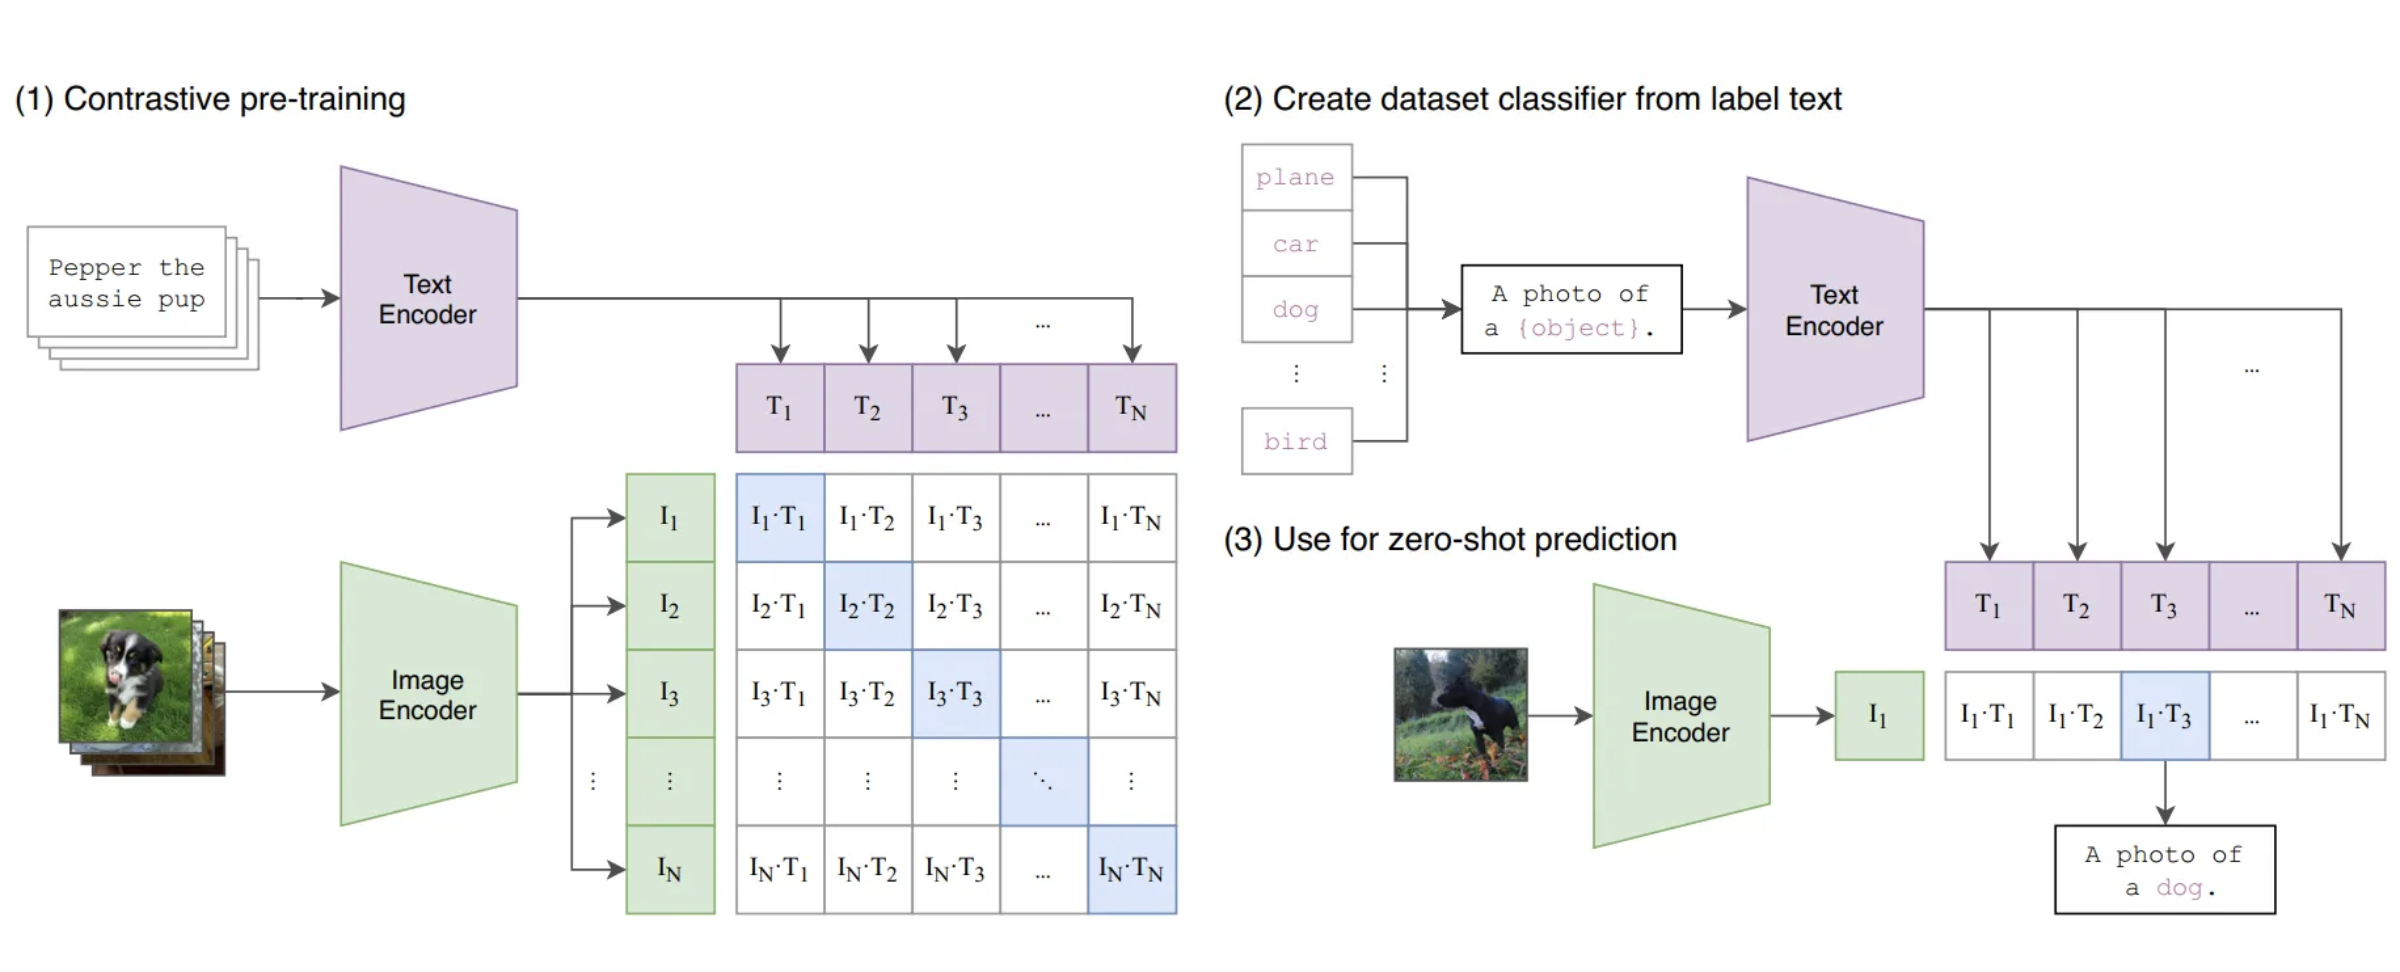

In [ ]:

class ClipEmbedding(nn.Module):
     
     # n_vocab : vocabulary size
     # n_embd : embedding dimension
     # n_token : sequence length / context length
    def __init__(self, n_vocab: int, n_embd:int, n_token:int):

        super().__init__()

        # converting token space to embedding dimension(cause we are working in the embedding space)
        self.token_embedding = nn.Embedding(n_vocab, n_embd)
        # positional embedding(all the values are initialized to zero), nn.Parameter makes it learnable(makes the gradient flow possible)
        self.position_embedding = nn.Parameter(torch.zeros(n_token,n_embd)) 

    def forward(self , tokens):

        # tokens : (batch_size , seq_len/context length)
        x = self.token_embedding(tokens)   # x : (batch_size , seq_len , n_embd) 
        x += self.position_embedding       # x : (batch_size , seq_len/context length , n_embd) + (n_token/seq_length , n_embd)  --> broadcasting happens here

        return x
    
class ClipLayer(nn.Module):

    def __init__(self, n_head: int, n_embd: int):
        super().__init__()

        self.layernorm_1 = nn.LayerNorm(n_embd)     #(batch_size , seq_len , n_embd)
        self.attention = SelfAttention(n_head, n_embd)  #(batch_size , seq_len , n_embd)
        self.layernorm_2 = nn.LayerNorm(n_embd)
        self.linear_1 = nn.Linear(n_embd, 4*n_embd)
        self.linear_2 = nn.Linear(4* n_embd, n_embd)

    def forward(self , x):

        residue = x     #residue , x = (batch_size , seq_len , n_embd)
        x = self.layernorm_1(x)     #(batch_size , seq_len , n_embd)

        #masked self attention
        x = self.attention(x , casual_mask = True)  #(batch_size , seq_len , n_embd)
        x += residue    #x: (batch_size , seq_len , n_embd)

        #feedforward network after the self attention

        residue = x     #(batch_size , seq_len , n_embd)
        x = self.layernorm_2(x)     #(batch_size , seq_len , n_embd)
        x = self.linear_1(x)        #(batch_size , seq_len , n_embd) -> (batch_size , seq_len , 4*n_embd)

        # dont know why 1.702
        x = x * torch.sigmoid(1.702 * x)  

        x = self.linear_2(x)        #(batch_size , seq_len , 4*n_embd) -> (batch_size , seq_len , n_embd)
        x += residue            #x: (batch_size , seq_len , n_embd)

        return x


class Clip(nn.Module):
    
    def __init__(self):

        super().__init__()

        self.embedding = ClipEmbedding(n_vocab=49408, n_embd=768, n_token=77)

        # applying attention with multiple head size 
        self.layers = nn.ModuleList([
            ClipLayer(n_head=12, n_embd=768) for i in range(12)
        ])
        self.layersnorms = nn.LayerNorm(768)

    def forward(self , tokens : torch.LongTensor) -> torch.FloatTensor:

        tokens = tokens.type(torch.long) #(batch_size , seq_len/context length)
        state = self.embedding(tokens)  # (batch_size , seq_len/context length , n_embd)

        # passing through the layers multiple times
        for layer in self.layers:
            state = layer(state)
        output = self.layersnorms(state)

        return output

- the token is a complete senetence which is first divided into sub word/sequences(n_token or context_length or sequence_len) and then each subword is proejcted into the n_embd space(which is done by self.token_embd)
- in clip model we are projecting the tokens into the n_embd dimension while in the self attention we are proejecting to d_embd , both are essentially the same thing differernt names are used to avoid confusiong 
- in clip model if we see the input is forst passsed intot he clip layers whoch conatins the attneiton mechanism and then a refined outpout is projected , the output is then again passed as the input for the next iterations , it is done 12 times (but why)
state_0 = embedding(tokens)
state_1 = layer_1(state_0)
state_2 = layer_2(state_1)
...
state_12 = layer_12(state_11)


# Diffusion backbone


In [ ]:
# simple neural network
class TimeEmbedding(nn.Module):

    def __init__(self, n_embd):

        super().__init__()

        self.linear_1 = nn.Linear(n_embd , 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd , n_embd)

    def forward(self, x):

        x = self.linear_1(x)
        x = F.silu(x)
        x = self.linear_2(x)

        return x

# upsampling block   
class Upsample(nn.Module):

    def __call__(self, channels):

        super().__init__()
        self.conv = nn.Conv2d(channels, channels , kernel_size=3, padding=1)

    def forward(self,x):

        x = F.interpolate(x , scale_factor=2 , mode="nearest")

        return self.conv(x)



In [ ]:

class UNet_AttentionBlock(nn.Module):

    def __init__(self,n_heads , n_embd , d_context = 786):

        super().__init__()
        
        channels = n_embd * n_heads

        self.groupnorm = nn.GroupNorm(32 , channels , eps = 1e-6)
        self.conv_input = nn.Conv2d(channels , channels, kernel_size=1 , padding=0)

        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_heads=n_heads , d_embd=channels, in_proj_bias=False)

        self.layernorm_2 = nn.LayerNorm(channels)
        self.attention_2 = CrossAttention(n_heads=n_heads, d_embd=channels , d_cross=d_context , in_proj_bias = False)

        self.layernorm_3 = nn.LayerNorm(channels)

        self.linear_geglu_1= nn.Linear(channels, 4 * channels * 2)  #later divided into 2 don't know why
        self.linear_geglu_2 = nn.Linear(channels, 4 * channels)

        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1 , padding=0)
    
    def forward(self, x , context):

        # x(data) = batch_size , features/channels , height , width
        # context(clip_model) = batch_size , seq_len/context_len , dim/channels

        residue_long = x
        
        x = self.groupnorm(x)   #(batch_size , channels , height , width)
        x = self.conv_input(x)  #(batch_size , channels , height , width)

        n , c , h , w = x.shape  #(batch_size , channels , height , width)

        x= x.view(n , c , h*w)  #(batch_size , channels , height*width)
        x = x.transpose(-1,-2)      #(batch_size , height*width , channels)

        # normalization + self_attention 

        residue_short = x   #(batch_size , height*width , channels)
        x = self.layernorm_1(x)     #(batch_size , height*width , channels)
        x = self.attention_1(x)   #(batch_size , height*width , channels)
        x += residue_short      #(batch_size , height*width , channels)

        # normalization + cross_attention
        residue_short = x       #(batch_size , height*width , channels)
        x = self.layernorm_2(x)     #(batch_size , height*width , channels)
        x = self.attention_2(x , context)       #(batch_size , height*width , channels)
        x += residue_short      #(batch_size , height*width , channels)

        residue_short = x    #(batch_size , height*width , channels)

        # normalization + feed forward with geglu and skip connection
        x = self.layernorm_3(x)    #(batch_size , height*width , channels)

        x , gate = self.linear_geglu_1(x).chunk(2 , dim=-1)     #(batch_size , height*width , channels) -> (batch_size , height*width , 2*4*channels) -> 2 * (batch_size , height*width , 4*channels)
        x = x * F.gelu(gate)    #(batch_size , height*width , 4*channels)
        x = self.linear_geglu_2(x)    #(batch_size , height*width , 4*channels) -> (batch_size , height*width , channels)

        x += residue_short  #(batch_size , height*width , channels)

        x = x.transpose(-1,-2)    #(batch_size , channels , height*width)
        x = x.view(n , c , h , w)   #(batch_size , channels , height , width)
        x = self.conv_output(x)    #(batch_size , channels , height , width)
        
        x += residue_long   #(batch_size , channels , height , width)

        return x


- geglu(gated linear unit with a Gelu activation) --> gated feed forward nerwork , where a single linear blcok is splitted intow two tensors , apply nonlinealruty to the agte and then multiply wiht the the other haly(element wise multiplication ) , this combinatio gives more prwe than the linear layer followed by the relu function (why don't know )

In [ ]:


class UNet_ResidualBlock(nn.Module):

    def __init__(self, in_channel , out_channel, n_time=1280):

        super().__init__()

        self.groupnorm_feature = nn.GroupNorm(32, in_channel)
        self.conv_feature = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)

        self.linear_time = nn.Linear(n_time, out_channel)

        self.groupnorm_merged = nn.GroupNorm(32, out_channel)
        self.conv_merged = nn.Conv2d(out_channel, out_channel, kernel_size=3 , padding=1)

        if in_channel == out_channel:
            self.residual_layer = nn.Identity()
        else :
            self.residual_layer = nn.Conv2d(in_channel, out_channel, kernel_size=1 , padding=0)

    def forward(self, feature , time):

        # feature : (batch_size , in_channel , height , width)
        # time : (1, 1280) --> might be learnable parameter of length 1280
        residue = feature       #(batch_size , in_channel , height , width)

        feature = self.groupnorm_feature(feature)   #(batch_size , in_channel , height , width)
        feature = F.silu(feature)                 #(batch_size , in_channel , height , width)
        feature = self.conv_feature(feature)    #(batch_size , out_channel , height , width)

        time = F.silu(time)     #(1, 1280)
        time = self.linear_time(time)       #(1,1280) -> (1, out_channel)

        # same time value is added to all the pixels of a particular channel
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)  #(batch_size , out_channel , height , width)
        merged = self.groupnorm_merged(merged)      #(batch_size , out_channel , height , width)
        merged = F.silu(merged)                     #(batch_size , out_channel , height , width)
        merged = self.conv_merged(merged)           #(batch_size , out_channel , height , width)

        return merged + self.residual_layer(residue)
    


In [ ]:
class SwitchSequential(nn.Sequential):

    def forward(self, x , context , time):
        
        for layer in self:

            if isinstance(layer , UNet_AttentionBlock):     # input x and clip context vector
                x = layer(x , context)

            elif isinstance(layer , UNet_ResidualBlock):
                x = layer(x, time)

            else:
                x = layer(x)
                
        return x


- need to know about the child moudle parent maodule and the 

In [ ]:
    
class UNet(nn.Module):

    def __init__(self):

        super().__init__()

        #(batch_size , 4 , height/8 , width/8) --> output from the vae model encoder
        self.encoders = nn.ModuleList([

            # (batch_size , 4 , height/8 , width/8) --> (batch_size , 320 , height/8 , width/8)
            SwitchSequential(nn.Conv2d(in_channels=4 , out_channels=320 , kernel_size=3 , padding=1)),
            # (batch_size , 320 , height/8 , width/8) --> (batch_size , 320 , height/8 , width/8) --> (batch_size , 320 , height/8 , width/8)
            SwitchSequential(UNet_ResidualBlock(in_channels=320 , out_channels=320), UNet_AttentionBlock(n_heads=8, n_embd=40)),    #320 = 8*40
            # (batch_size , 320 , height/8 , width/8) --> (batch_size , 320 , height/8 , width/8) --> (batch_size , 320 , height/8 , width/8)
            SwitchSequential(UNet_ResidualBlock(in_channels=320 , out_channels=320), UNet_AttentionBlock(n_heads=8, n_embd=40)),


            #(batch_size , 320 , height/8 , width/8) --> (batch_size , 320 , height/16 , width/16)
            SwitchSequential(nn.Conv2d(in_channels=320, out_channels=320 , kernel_size=3, stride=2 , padding=1)),
            # (batch_size , 320 , height/16 , width/16) --> (batch_size , 640 , height/16 , width/16) --> (batch_size , 640 , height/16 , width/16)
            SwitchSequential(UNet_ResidualBlock(in_channels=320 , out_channels=640), UNet_AttentionBlock(n_heads=8, n_embd=80)),    #640 = 8*80
            # (batch_size , 640 , height/16 , width/16) --> (batch_size , 640 , height/16 , width/16) --> (batch_size , 640 , height/16 , width/16)
            SwitchSequential(UNet_ResidualBlock(in_channels=640 , out_channels=640), UNet_AttentionBlock(n_heads=8, n_embd=80)),    #640 = 8*80


            #(batch_size , 640 , height/16 , width/16) --> (batch_size , 640 , height/32 , width/32)
            SwitchSequential(nn.Conv2d(640, 640 , kernel_size=3, stride=2 , padding=1)),
            # (batch_size , 640 , height/32 , width/32) --> (batch_size , 1280 , height/32 , width/32) --> (batch_size , 1280 , height/32 , width/32)
            SwitchSequential(UNet_ResidualBlock( 640, 1280), UNet_AttentionBlock(8,160)),   #1280 = 8*160
            # (batch_size , 1280 , height/32 , width/32) --> (batch_size , 1280 , height/32 , width/32) --> (batch_size , 1280 , height/32 , width/32)
            SwitchSequential(UNet_ResidualBlock(128 , 1280), UNet_AttentionBlock(8,160)),   #1280 = 8*160


            #(batch_size , 1280 , height/32 , width/32) --> (batch_size , 1280 , height/64 , width/64)
            SwitchSequential(nn.Conv2d(1280, 1280 , kernel_size=3, stride=2 , padding=1)),
            # (batch_size , 1280 , height/64 , width/64) --> (batch_size , 1280 , height/64 , width/64) --> (batch_size , 1280 , height/64 , width/64)
            SwitchSequential(UNet_ResidualBlock(1280 , 1280)),
            # (batch_size , 1280 , height/64 , width/64) --> (batch_size , 1280 , height/64 , width/64) --> (batch_size , 1280 , height/64 , width/64)
            SwitchSequential(UNet_ResidualBlock(1280 , 1280)),

        ])
        self.bottleneck = SwitchSequential(
            # (batch_size , 1280 , height/64 , width/64) --> (batch_size , 1280 , height/64 , width/64)
            UNet_ResidualBlock(1280,1280),
            
            # (batch_size , 1280 , height/64 , width/64) --> (batch_size , 1280 , height/64 , width/64)
            UNet_AttentionBlock(8,160),     #1280 = 8*160

            # (batch_size , 1280 , height/64 , width/64) --> (batch_size , 1280 , height/64 , width/64)
            UNet_ResidualBlock(1280,1280),
        )

        self.decoders = nn.ModuleList([

            
            #(batch_size , 2560 , height/64 , width/64) --> (batch_size , 1280 , height/64 , width/64)
            SwitchSequential(UNet_ResidualBlock(2560 , 1280)),  
            #(batch_size , 1280 , height/64 , width/64) --> (batch_size , 1280 , height/64 , width/64)
            SwitchSequential(UNet_ResidualBlock(2560 , 1280)),


            #(batch_size , 2560 , height/64 , width/64) --> (batch_size , 1280 , height/64 , width/64) --> (batch_size , 1280 , height/32 , width/32)
            SwitchSequential(UNet_ResidualBlock(2560 , 1280), Upsample(1280)),
            #(batch_size , 2560 , height/32 , width/32) --> (batch_size , 1280 , height/64 , width/64) --> (batch_size , 1280 , height/32 , width/32)
            SwitchSequential(UNet_ResidualBlock(2560 , 1280), UNet_AttentionBlock(8,160)),  #1280 = 8*160
            #(batch_size , 2560 , height/32 , width/32) --> (batch_size , 1280 , height/32 , width/32) --> (batch_size , 1280 , height/32 , width/32)
            SwitchSequential(UNet_ResidualBlock(2560, 1280), UNet_AttentionBlock(8,160)),

            #(batch_size , 1920 , height/32 , width/32) --> (batch_size , 1280 , height/32 , width/32) --> (batch_size , 1280 , height/32 , width/32) --> (batch_size , 1280 , height/16 , width/16)
            SwitchSequential(UNet_ResidualBlock(1920 , 1280), UNet_AttentionBlock(8,160), Upsample(1280)),  #1280 = 8*160
            #(batch_size , 1920 , height/16 , width/16) --> (batch_size , 640 , height/16 , width/16) --> (batch_size , 640 , height/16 , width/16)
            SwitchSequential(UNet_ResidualBlock(1920 , 640), UNet_AttentionBlock(8 , 80)),  #640 = 8*80
            #(batch_size , 960 , height/16 , width/16) --> (batch_size , 640 , height/16 , width/16) --> (batch_size , 640 , height/16 , width/16)
            SwitchSequential(UNet_ResidualBlock(960 , 640), UNet_AttentionBlock(8 , 80)),   #640 = 8*80
            #(batch_size , 960 , height/16 , width/16) --> (batch_size , 640 , height/16 , width/16) --> (batch_size , 640 , height/8 , width/8)
            SwitchSequential(UNet_ResidualBlock(960 , 640), UNet_AttentionBlock(8 , 80), Upsample(640)),    #640 = 8*80
            #(batch_size , 960 , height/8 , width/8) --> (batch_size , 320 , height/8 , width/8) --> (batch_size , 320 , height/8 , width/8)
            SwitchSequential(UNet_ResidualBlock(960 , 320), UNet_AttentionBlock(8 , 40)),   #320 = 8*40
            #(batch_size , 640 , height/8 , width/8) --> (batch_size , 320 , height/8 , width/8) --> (batch_size , 320 , height/4 , width/4)
            SwitchSequential(UNet_ResidualBlock(640 , 320), UNet_AttentionBlock(8 , 80)),   #320 = 8*40
            #(batch_size , 640 , height/4 , width/4) --> (batch_size , 320 , height/4 , width/4) --> (batch_size , 320 , height/4 , width/4)
            SwitchSequential(UNet_ResidualBlock(640 , 320), UNet_AttentionBlock(8 , 40)),   #320 = 8*40

        ])

    def forward(self, x , context , time):

        # x : (batch_size , 4 , height/8 , width/8)
        # context : (batch_size , seq_len/context length , dim/channels)
        # time : (1, 1280) --> might be learnable parameter of length 1280

        # saving the values for skip connections
        skip_connections = []

        # encoders
        for encoder in self.encoders:
            x = encoder(x , context , time)   #(batch_size , channels , height , width)
            skip_connections.append(x)

        # bottleneck
        x = self.bottleneck(x , context , time)   #(batch_size , channels , height , width)

        # decoders
        for decoder in self.decoders:
            skip_connection = skip_connections.pop()
            # adding the channel dimension
            x = torch.cat((x , skip_connection), dim=1)   #(batch_size , channels , height , width)
            x = decoder(x , context , time)    #(batch_size , channels , height , width)

        return x


- the output of the enocde from the vae was very high dimenstional latent vector 
- in the typical unet diffusion architrecture there are different types of residual connect first is the internal residual connect within each layer and second is the skip connection between the encoder and the decoder block
-  #differnce betweeen module and modulelist
- in the decoder block at each layer the number of channels is dobled because of the skip connection from the encoder block 
- notice that the dimension of channel in the decoder part is not symmetrucal becuase the skip connection whaich are added from the encoder part have different number of channels as the decoder part , ven thought they are in the same resoultion( just want to know why this was the architecture choice why syymmetrical u net was not chosen , why , also the attention layers are much more less in deocder part as the encoder part why)

In [ ]:
# this is applied at the end of unet to convert the 320 channels to 4 channels
class UNet_output_layer(nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()

        self.groupnorm= nn.GroupNorm(32, in_channels)  
        self.conv = nn.Conv2d(in_channels , out_channels, kernel_size=3 , padding=1)
    
    def forward(self, x):

        x = self.groupnorm(x)
        x = F.silu(x)
        x = self.conv(x)

        return x

class Diffusion(nn.Module):

    def __init__(self):

        super().__init__()

        self.time_embedding = TimeEmbedding(320)    # (1,320) --> (1,1280)
        self.unet = UNet()  # backbone unet model
        self.final = UNet_output_layer(320,4)   #converting 320 channels to 4 channels

    def forward(self, latent , context , time):

        #time : (1,320)
        # latent : (batch_size , 4 , height/8 , width/8)
        # context : (batch_size , seq_len/context length , dim/channels)

        time = self.time_embedding(time)
        output = self.unet(latent , context , time)  #(batch_size , 4 , height/8 , width/8) -> (batch_size , 320 , height/8 , width/8)
        output = self.final(output)  #(batch_size , 320 , height/8 , width/8) -> (batch_size , 4 , height/8 , width/8)

        return output
    



- kernal size 3 woiht padding 1 keeps the sam eresolution 
- kernal size 1 with padding 0 could be seen as the intermisxing of the channels layers
- need to have the clarity of the time dimension 

In [10]:
a=nn.Parameter(torch.tensor([0.0,0.0,0.0]))
print(a)

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)
